# Setup and imports

In [95]:
# imports
import numpy as np
from tueplots import bundles, figsizes
import wandb
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import pandas as pd


import sys

%load_ext autoreload
%autoreload 2

sys.path.insert(0, '.')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [96]:
from analysis import sweep2df, plot_typography, stats2string, RED, BLUE, rule_stats2string_per_model

In [97]:
USETEX = True

In [98]:
plt.rcParams.update(bundles.icml2022(usetex=USETEX))
# plt.rcParams.update({
#     'text.latex.preamble': [r'\usepackage{amsfonts}', # mathbb
#                             r'\usepackage{amsmath}'] # boldsymbol
# })

In [99]:
plot_typography(usetex=USETEX, small=12, medium=16, big=20)


In [100]:
# Constants
ENTITY = "causal-representation-learning"
PROJECT = "rule_extrapolation"

# W&B API
api = wandb.Api(timeout=200)
runs = api.runs(ENTITY + "/" + PROJECT)

# Data loading

## baN

In [122]:
SWEEP_ID = "y2193u7e"
sweep = api.sweep(f"{ENTITY}/{PROJECT}/{SWEEP_ID}")
filename = f"ban_{SWEEP_ID}"
ban_df,ban_train_loss,ban_val_loss,ban_val_kl,ban_val_accuracy,ban_finised,ban_ood_finised,ban_sos_finised,ban_r1,ban_r2,ban_grammatical,ban_ood_r1,ban_ood_r1_completion,ban_ood_r2,ban_ood_grammatical,ban_sos_r1,ban_sos_r2,ban_sos_grammatical= sweep2df(sweep.runs, filename, save=True, load=False)

## bbaN

In [114]:
SWEEP_ID = "f9m6ueta"  #"49rb3sn2"
sweep = api.sweep(f"{ENTITY}/{PROJECT}/{SWEEP_ID}")
filename = f"bban_{SWEEP_ID}"
bban_df,bban_train_loss,bban_val_loss,bban_val_kl,bban_val_accuracy,bban_finised,bban_ood_finised,bban_sos_finised,bban_r1,bban_r2,bban_grammatical,bban_ood_r1,bban_ood_r1_completion,bban_ood_r2,bban_ood_grammatical,bban_sos_r1,bban_sos_r2,bban_sos_grammatical= sweep2df(sweep.runs, filename, save=True, load=False)

In [115]:
SWEEP_ID = "49rb3sn2"
sweep = api.sweep(f"{ENTITY}/{PROJECT}/{SWEEP_ID}")
filename = f"bban_non_transformer_15k_{SWEEP_ID}"
bban_non_transformer_15k_df,bban_non_transformer_15k_train_loss,bban_non_transformer_15k_val_loss,bban_non_transformer_15k_val_kl,bban_non_transformer_15k_val_accuracy,bban_non_transformer_15k_finised,bban_non_transformer_15k_ood_finised,bban_non_transformer_15k_sos_finised,bban_non_transformer_15k_r1,bban_non_transformer_15k_r2,bban_non_transformer_15k_grammatical,bban_non_transformer_15k_ood_r1,bban_non_transformer_15k_ood_r1_completion,bban_non_transformer_15k_ood_r2,bban_non_transformer_15k_ood_grammatical,bban_non_transformer_15k_sos_r1,bban_non_transformer_15k_sos_r2,bban_non_transformer_15k_sos_grammatical= sweep2df(sweep.runs, filename, save=True, load=False)

In [116]:
SWEEP_ID = "qne9hmbu"  #"49rb3sn2"
sweep = api.sweep(f"{ENTITY}/{PROJECT}/{SWEEP_ID}")
filename = f"bban_transformer_15k_{SWEEP_ID}"
bban_transformer_15k_df,bban_transformer_15k_train_loss,bban_transformer_15k_val_loss,bban_transformer_15k_val_kl,bban_transformer_15k_val_accuracy,bban_transformer_15k_finised,bban_transformer_15k_ood_finised,bban_transformer_15k_sos_finised,bban_transformer_15k_r1,bban_transformer_15k_r2,bban_transformer_15k_grammatical,bban_transformer_15k_ood_r1,bban_transformer_15k_ood_r1_completion,bban_transformer_15k_ood_r2,bban_transformer_15k_ood_grammatical,bban_transformer_15k_sos_r1,bban_transformer_15k_sos_r2,bban_transformer_15k_sos_grammatical= sweep2df(sweep.runs, filename, save=True, load=False)

In [117]:
bban_df_merged = pd.concat([bban_df, bban_non_transformer_15k_df, bban_transformer_15k_df])

## aNbN

In [123]:
SWEEP_ID = "nfrfpkqm"
sweep = api.sweep(f"{ENTITY}/{PROJECT}/{SWEEP_ID}")
filename = f"anbn_{SWEEP_ID}"
anbn_df,anbn_train_loss,anbn_val_loss,anbn_val_kl,anbn_val_accuracy,anbn_finised,anbn_ood_finised,anbn_sos_finised,anbn_r1,anbn_r2,anbn_grammatical,anbn_ood_r1,anbn_ood_r1_completion,anbn_ood_r2,anbn_ood_grammatical,anbn_sos_r1,anbn_sos_r2,anbn_sos_grammatical= sweep2df(sweep.runs, filename, save=True, load=False)

In [124]:
SWEEP_ID = "t4yzbech"
sweep = api.sweep(f"{ENTITY}/{PROJECT}/{SWEEP_ID}")
filename = f"anbn_lstm_{SWEEP_ID}"
anbn_lstm_df,anbn_lstm_train_loss,anbn_lstm_val_loss,anbn_lstm_val_kl,anbn_lstm_val_accuracy,anbn_lstm_finised,anbn_lstm_ood_finised,anbn_lstm_sos_finised,anbn_lstm_r1,anbn_lstm_r2,anbn_lstm_grammatical,anbn_lstm_ood_r1,anbn_lstm_ood_r1_completion,anbn_lstm_ood_r2,anbn_lstm_ood_grammatical,anbn_lstm_sos_r1,anbn_lstm_sos_r2,anbn_lstm_sos_grammatical= sweep2df(sweep.runs, filename, save=True, load=False)

In [125]:
SWEEP_ID = "o27zaphz"
sweep = api.sweep(f"{ENTITY}/{PROJECT}/{SWEEP_ID}")
filename = f"anbn_mamba_{SWEEP_ID}"
anbn_mamba_df,anbn_mamba_train_loss,anbn_mamba_val_loss,anbn_mamba_val_kl,anbn_mamba_val_accuracy,anbn_mamba_finised,anbn_mamba_ood_finised,anbn_mamba_sos_finised,anbn_mamba_r1,anbn_mamba_r2,anbn_mamba_grammatical,anbn_mamba_ood_r1,anbn_mamba_ood_r1_completion,anbn_mamba_ood_r2,anbn_mamba_ood_grammatical,anbn_mamba_sos_r1,anbn_mamba_sos_r2,anbn_mamba_sos_grammatical= sweep2df(sweep.runs, filename, save=True, load=False)

In [126]:
anbn_df_merged = pd.concat([anbn_df, anbn_lstm_df, anbn_mamba_df])

## aNbNcN

In [127]:
SWEEP_ID = "6m1qb70e"
sweep = api.sweep(f"{ENTITY}/{PROJECT}/{SWEEP_ID}")
filename = f"anbncn_{SWEEP_ID}"
anbncn_df,anbncn_train_loss,anbncn_val_loss,anbncn_val_kl,anbncn_val_accuracy,anbncn_finised,anbncn_ood_finised,anbncn_sos_finised,anbncn_r1,anbncn_r2,anbncn_grammatical,anbncn_ood_r1,anbncn_ood_r1_completion,anbncn_ood_r2,anbncn_ood_grammatical,anbncn_sos_r1,anbncn_sos_r2,anbncn_sos_grammatical= sweep2df(sweep.runs, filename, save=True, load=False)

In [128]:
SWEEP_ID = "vtji6cx4"
sweep = api.sweep(f"{ENTITY}/{PROJECT}/{SWEEP_ID}")
filename = f"anbncn_lin_mamba_{SWEEP_ID}"
anbncn_lin_mamba_df,anbncn_lin_mamba_train_loss,anbncn_lin_mamba_val_loss,anbncn_lin_mamba_val_kl,anbncn_lin_mamba_val_accuracy,anbncn_lin_mamba_finised,anbncn_lin_mamba_ood_finised,anbncn_lin_mamba_sos_finised,anbncn_lin_mamba_r1,anbncn_lin_mamba_r2,anbncn_lin_mamba_grammatical,anbncn_lin_mamba_ood_r1,anbncn_lin_mamba_ood_r1_completion,anbncn_lin_mamba_ood_r2,anbncn_lin_mamba_ood_grammatical,anbncn_lin_mamba_sos_r1,anbncn_lin_mamba_sos_r2,anbncn_lin_mamba_sos_grammatical= sweep2df(sweep.runs, filename, save=True, load=False)

In [129]:
anbncn_df_merged = pd.concat([anbncn_df, anbncn_lin_mamba_df])

## Matched brackets and parentheses

In [131]:
SWEEP_ID = "r9wywplg"
sweep = api.sweep(f"{ENTITY}/{PROJECT}/{SWEEP_ID}")
filename = f"brackets_{SWEEP_ID}"
brackets_df,brackets_train_loss,brackets_val_loss,brackets_val_kl,brackets_val_accuracy,brackets_finised,brackets_ood_finised,brackets_sos_finised,brackets_r1,brackets_r2,brackets_grammatical,brackets_ood_r1,brackets_ood_r1_completion,brackets_ood_r2,brackets_ood_grammatical,brackets_sos_r1,brackets_sos_r2,brackets_sos_grammatical= sweep2df(sweep.runs, filename, save=True, load=False)

In [132]:
SWEEP_ID = "g6yifhbz"
sweep = api.sweep(f"{ENTITY}/{PROJECT}/{SWEEP_ID}")
filename = f"brackets_lin_mamba_{SWEEP_ID}"
brackets_lin_mamba_df,brackets_lin_mamba_train_loss,brackets_lin_mamba_val_loss,brackets_lin_mamba_val_kl,brackets_lin_mamba_val_accuracy,brackets_lin_mamba_finised,brackets_lin_mamba_ood_finised,brackets_lin_mamba_sos_finised,brackets_lin_mamba_r1,brackets_lin_mamba_r2,brackets_lin_mamba_grammatical,brackets_lin_mamba_ood_r1,brackets_lin_mamba_ood_r1_completion,brackets_lin_mamba_ood_r2,brackets_lin_mamba_ood_grammatical,brackets_lin_mamba_sos_r1,brackets_lin_mamba_sos_r2,brackets_lin_mamba_sos_grammatical= sweep2df(sweep.runs, filename, save=True, load=False)

In [133]:
brackets_df_merged = pd.concat([brackets_df, brackets_lin_mamba_df])

## Human study

In [ ]:
human_df = pd.read_excel("human_study.xlsx")

In [ ]:
human_df

In [ ]:
# processing steps
# strips whitespace
# convert characters to lowercase
# convert symbols to the tokens in data.py


# Plots

## helper functions


In [103]:
# group by model

def grouped_rule_stats(df):
    grouped_df = df.groupby("model")

    stats = {}

    stats["val_loss"] = grouped_df.min_val_loss

    stats["rule_1"] = grouped_df.rule_1_accuracy4min_val_loss
    stats["rule_2"] = grouped_df.rule_2_accuracy4min_val_loss
    stats["grammatical"] = grouped_df.grammatical_accuracy4min_val_loss
    stats["finished"] = grouped_df.finished4min_val_loss

    stats["ood_rule_1"] = grouped_df.ood_rule_1_accuracy4min_val_loss
    stats["ood_rule_2"] = grouped_df.ood_rule_2_accuracy4min_val_loss
    stats["ood_rule_2_completion"] = grouped_df.ood_rule_2_completion_accuracy4min_val_loss
    stats["ood_grammatical"] = grouped_df.ood_grammatical_accuracy4min_val_loss
    stats["ood_finished"] = grouped_df.ood_finished4min_val_loss

    stats["sos_rule_1"] = grouped_df.sos_rule_1_accuracy4min_val_loss
    stats["sos_rule_2"] = grouped_df.sos_rule_2_accuracy4min_val_loss
    stats["sos_grammatical"] = grouped_df.sos_grammatical_accuracy4min_val_loss
    stats["sos_finished"] = grouped_df.sos_finished4min_val_loss

    return stats


In [134]:
ban_stats = grouped_rule_stats(ban_df)
bban_stats = grouped_rule_stats(bban_df_merged)
anbn_stats = grouped_rule_stats(anbn_df_merged)
anbncn_stats = grouped_rule_stats(anbncn_df_merged)
brackets_stats = grouped_rule_stats(brackets_df_merged)

In [105]:
def plot_loss_vs_rules(df, stats, cmap="coolwarm", TICK_PADDING=2, LABELPAD=1, filename=None):

    colors = {
        "transformer": "tab:blue",
        "lstm": "tab:orange",
        "linear": "tab:green",
        "mamba": "tab:red"
        }


    fig = plt.figure(figsize=figsizes.icml2022_full(nrows=1, ncols=2)['figure.figsize'])
    ax = fig.add_subplot(121)
    ax.grid(True, which="both", ls="-.")
    ax.set_axisbelow(True)
    for model in stats["val_loss"].groups.keys():

        im = ax.scatter(df[df.model == model].min_val_loss,
                        100 * df[df.model == model].ood_rule_1_accuracy4min_val_loss, c=colors[model], label=model)
    ax.set_ylabel("R1 \%", labelpad=LABELPAD)
    ax.set_xlabel("Minimum test loss", labelpad=LABELPAD)
    # plt.legend()
    ax.tick_params(axis='both', which='major', pad=TICK_PADDING)
    ax = fig.add_subplot(122)
    ax.grid(True, which="both", ls="-.")
    ax.set_axisbelow(True)
    for model in stats["val_loss"].groups.keys():
        im = ax.scatter(df[df.model == model].min_val_loss,
                        100 * df[df.model == model].ood_rule_2_completion_accuracy4min_val_loss, c=colors[model], label=model)
    ax.set_ylabel("R2 completion (\%)", labelpad=LABELPAD)
    ax.set_xlabel("Minimum test loss", labelpad=LABELPAD)
    plt.legend(loc='lower center')
    ax.tick_params(axis='both', which='major', pad=TICK_PADDING)

    if filename is not None:
        plt.savefig(f"{filename}.svg")

## baN

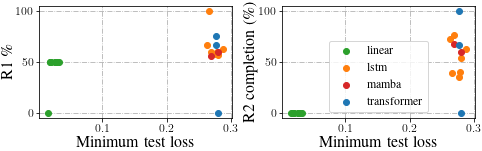

In [135]:
plot_loss_vs_rules(ban_df, ban_stats, filename="ban_loss_vs_rules")

In [145]:
rule_stats2string_per_model(ban_stats)

------------------------------
Model order is=['linear', 'lstm', 'mamba', 'transformer']
Plot order is=('val_loss', 'rule_1', 'rule_2', 'ood_rule_1', 'ood_rule_2_completion')
------------------------------
Linear &$0.023\scriptscriptstyle\pm 0.006$ & $0.438\scriptscriptstyle\pm 0.177$ & $0.875\scriptscriptstyle\pm 0.354$ & $0.438\scriptscriptstyle\pm 0.177$ & $0.000\scriptscriptstyle\pm 0.000$ & 
Lstm &$0.275\scriptscriptstyle\pm 0.009$ & $0.958\scriptscriptstyle\pm 0.012$ & $1.000\scriptscriptstyle\pm 0.000$ & $0.661\scriptscriptstyle\pm 0.153$ & $0.543\scriptscriptstyle\pm 0.168$ & 
Mamba &$0.275\scriptscriptstyle\pm 0.007$ & $0.965\scriptscriptstyle\pm 0.005$ & $1.000\scriptscriptstyle\pm 0.000$ & $0.578\scriptscriptstyle\pm 0.031$ & $0.639\scriptscriptstyle\pm 0.055$ & 
Transformer &$0.278\scriptscriptstyle\pm 0.002$ & $0.333\scriptscriptstyle\pm 0.577$ & $1.000\scriptscriptstyle\pm 0.000$ & $0.472\scriptscriptstyle\pm 0.411$ & $0.556\scriptscriptstyle\pm 0.509$ & 


[]

## bbaN

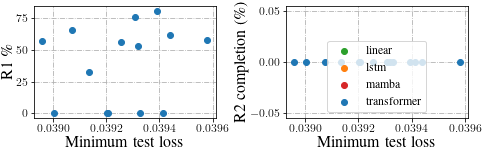

In [136]:
plot_loss_vs_rules(bban_df, bban_stats, filename="bban_loss_vs_rules")

In [137]:
rule_stats2string_per_model(bban_stats)

------------------------------
Model order is=['linear', 'lstm', 'mamba', 'transformer']
Plot order is=('val_loss', 'rule_1', 'rule_2', 'ood_rule_1', 'ood_rule_2_completion')
------------------------------
Linear &$0.022\scriptscriptstyle\pm 0.005$ & $0.367\scriptscriptstyle\pm 0.022$ & $1.000\scriptscriptstyle\pm 0.000$ & $0.473\scriptscriptstyle\pm 0.050$ & $0.000\scriptscriptstyle\pm 0.000$ & 
Lstm &$0.037\scriptscriptstyle\pm 0.000$ & $1.000\scriptscriptstyle\pm 0.000$ & $1.000\scriptscriptstyle\pm 0.000$ & $1.000\scriptscriptstyle\pm 0.000$ & $0.000\scriptscriptstyle\pm 0.000$ & 
Mamba &$0.039\scriptscriptstyle\pm nan$ & $1.000\scriptscriptstyle\pm nan$ & $1.000\scriptscriptstyle\pm nan$ & $1.000\scriptscriptstyle\pm nan$ & $0.000\scriptscriptstyle\pm nan$ & 
Transformer &$0.040\scriptscriptstyle\pm 0.001$ & $0.165\scriptscriptstyle\pm 0.295$ & $0.270\scriptscriptstyle\pm 0.450$ & $0.169\scriptscriptstyle\pm 0.280$ & $0.000\scriptscriptstyle\pm 0.000$ & 


[]

## aNbN

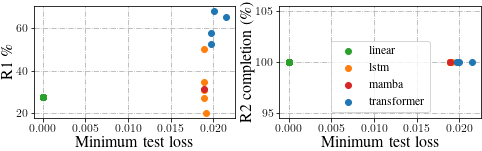

In [138]:
plot_loss_vs_rules(anbn_df, anbn_stats, filename="anbn_loss_vs_rules")

In [139]:
rule_stats2string_per_model(anbn_stats)

------------------------------
Model order is=['linear', 'lstm', 'mamba', 'transformer']
Plot order is=('val_loss', 'rule_1', 'rule_2', 'ood_rule_1', 'ood_rule_2_completion')
------------------------------
Linear &$0.000\scriptscriptstyle\pm 0.000$ & $0.200\scriptscriptstyle\pm 0.000$ & $1.000\scriptscriptstyle\pm 0.000$ & $0.275\scriptscriptstyle\pm 0.000$ & $1.000\scriptscriptstyle\pm 0.000$ & 
Lstm &$0.019\scriptscriptstyle\pm 0.000$ & $1.000\scriptscriptstyle\pm 0.000$ & $1.000\scriptscriptstyle\pm 0.000$ & $0.376\scriptscriptstyle\pm 0.209$ & $1.000\scriptscriptstyle\pm 0.000$ & 
Mamba &$0.019\scriptscriptstyle\pm 0.000$ & $1.000\scriptscriptstyle\pm 0.000$ & $1.000\scriptscriptstyle\pm 0.000$ & $0.290\scriptscriptstyle\pm 0.040$ & $1.000\scriptscriptstyle\pm 0.000$ & 
Transformer &$0.020\scriptscriptstyle\pm 0.001$ & $1.000\scriptscriptstyle\pm 0.000$ & $1.000\scriptscriptstyle\pm 0.000$ & $0.609\scriptscriptstyle\pm 0.071$ & $1.000\scriptscriptstyle\pm 0.000$ & 


[]

## aNbNcN

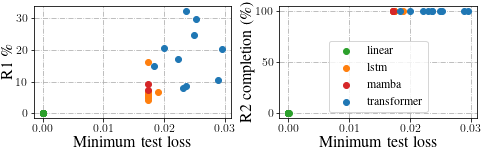

In [140]:
plot_loss_vs_rules(anbncn_df, anbncn_stats, filename="anbncn_loss_vs_rules")

In [141]:
rule_stats2string_per_model(anbncn_stats)

------------------------------
Model order is=['linear', 'lstm', 'mamba', 'transformer']
Plot order is=('val_loss', 'rule_1', 'rule_2', 'ood_rule_1', 'ood_rule_2_completion')
------------------------------
Linear &$0.000\scriptscriptstyle\pm 0.000$ & $0.000\scriptscriptstyle\pm 0.000$ & $0.000\scriptscriptstyle\pm 0.000$ & $0.000\scriptscriptstyle\pm 0.000$ & $0.000\scriptscriptstyle\pm 0.000$ & 
Lstm &$0.017\scriptscriptstyle\pm 0.001$ & $1.000\scriptscriptstyle\pm 0.000$ & $1.000\scriptscriptstyle\pm 0.000$ & $0.068\scriptscriptstyle\pm 0.036$ & $1.000\scriptscriptstyle\pm 0.000$ & 
Mamba &$0.017\scriptscriptstyle\pm 0.000$ & $1.000\scriptscriptstyle\pm 0.000$ & $1.000\scriptscriptstyle\pm 0.000$ & $0.090\scriptscriptstyle\pm 0.016$ & $1.000\scriptscriptstyle\pm 0.000$ & 
Transformer &$0.024\scriptscriptstyle\pm 0.003$ & $1.000\scriptscriptstyle\pm 0.000$ & $1.000\scriptscriptstyle\pm 0.000$ & $0.187\scriptscriptstyle\pm 0.085$ & $1.000\scriptscriptstyle\pm 0.000$ & 


[]

## Matched brackets and parentheses

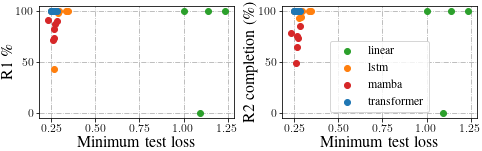

In [142]:
plot_loss_vs_rules(brackets_df, brackets_stats, filename="brackets_loss_vs_rules")

In [143]:
rule_stats2string_per_model(brackets_stats)

------------------------------
Model order is=['linear', 'lstm', 'mamba', 'transformer']
Plot order is=('val_loss', 'rule_1', 'rule_2', 'ood_rule_1', 'ood_rule_2_completion')
------------------------------
Linear &$1.076\scriptscriptstyle\pm 0.066$ & $0.909\scriptscriptstyle\pm 0.302$ & $0.909\scriptscriptstyle\pm 0.302$ & $0.909\scriptscriptstyle\pm 0.302$ & $0.909\scriptscriptstyle\pm 0.302$ & 
Lstm &$0.289\scriptscriptstyle\pm 0.035$ & $1.000\scriptscriptstyle\pm 0.000$ & $1.000\scriptscriptstyle\pm 0.000$ & $0.926\scriptscriptstyle\pm 0.198$ & $0.984\scriptscriptstyle\pm 0.030$ & 
Mamba &$0.268\scriptscriptstyle\pm 0.016$ & $0.803\scriptscriptstyle\pm 0.152$ & $0.831\scriptscriptstyle\pm 0.131$ & $0.810\scriptscriptstyle\pm 0.103$ & $0.716\scriptscriptstyle\pm 0.136$ & 
Transformer &$0.266\scriptscriptstyle\pm 0.015$ & $1.000\scriptscriptstyle\pm 0.000$ & $1.000\scriptscriptstyle\pm 0.000$ & $1.000\scriptscriptstyle\pm 0.000$ & $1.000\scriptscriptstyle\pm 0.000$ & 


[]

## Plot for all languages

/usr/local/lib/python3.9/site-packages/matplotlib/axes/_base.py:2283: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


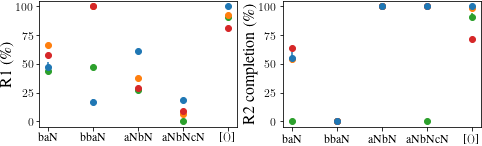

In [144]:
TICK_PADDING = 2
LABELPAD = 1
cmap = "coolwarm"

stats_dict = {
    "baN": ban_stats,
    "bbaN": bban_stats,
    "aNbN": anbn_stats,
    "aNbNcN": anbncn_stats,
    "[()]": brackets_stats
}

colors = {
        "transformer": "tab:blue",
        "lstm": "tab:orange",
        "linear": "tab:green",
        "mamba": "tab:red"
        }


x_pos = list(range(len(stats_dict)))

fig = plt.figure(figsize=figsizes.icml2022_full(nrows=1, ncols=2)['figure.figsize'])

ax = fig.add_subplot(121)
# ax.grid(True, which="both", ls="-.")
# ax.set_axisbelow(True)

for x, (key, stats) in enumerate(stats_dict.items()):
    for model in stats["val_loss"].groups.keys():

        ax.errorbar(x, 100*stats["ood_rule_1"].get_group(model).mean(), yerr=10*stats["ood_rule_1"].get_group(model).std(), fmt='o',label=model, c=colors[model])


ax.set_ylabel("R1 (\%)", labelpad=LABELPAD)

# set xtick names
ax.set_xticks(x_pos)
ax.set_xticklabels(stats_dict.keys())

ax2 = fig.add_subplot(122)

for x, (key, stats) in enumerate(stats_dict.items()):
    for model in stats["val_loss"].groups.keys():
        ax2.errorbar(x, 100*stats["ood_rule_2_completion"].get_group(model).mean(), yerr=10*stats["ood_rule_2_completion"].get_group(model).std(), fmt='o',c=colors[model], label = model)


# set xtick names
ax2.set_xticks(x_pos)
ax2.set_xticklabels(stats_dict.keys())
ax2.set_ylabel("R2 completion (\%)", labelpad=LABELPAD)


# plt.legend()
ax.tick_params(axis='both', which='major', pad=TICK_PADDING)
